## Introduction

## Import

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import json
import re

## Data ingestion

In [25]:
def process_large_json(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line)
            data.append({
                'title': record['title'],
                'text': record['text'],
                'date': record['date'],
                'article': record['article']
            })
    df = pd.DataFrame(data)
    return df

In [26]:
file_path = 'newspapers.jsonl'
df = process_large_json(file_path)

## Data exploration

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   title    100000 non-null  object
 1   text     100000 non-null  object
 2   date     100000 non-null  object
 3   article  100000 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


In [28]:
df.describe()

title  \
count                                         100000   
unique                                         99045   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                              100000   
unique                                              86557   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                    100000   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article  
count                                              100000  
unique                                             100000  
top     2047761 at https://france3-regions.francetvinf...  
freq                                                    1

In [29]:
df.drop_duplicates(subset=['text', 'title'], inplace=True)

In [30]:
df.describe()

title  \
count                                          99427   
unique                                         99045   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               99427   
unique                                              86557   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     99427   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article  
count                                               99427  
unique                                              99427  
top     2047761 at https://france3-regions.francetvinf...  
freq                                                    1

In [31]:
df.head()

title  \
0  International de Sète : la pétanque, une affai...   
1  Massif des Vosges. La route des Crêtes fermée ...   
2  Savoie. Discrimination raciale: quatre chauffe...   
3  TÉMOIGNAGE. Les Restos du Coeur recrutent : "o...   
4  Mars bleu, pour favoriser le dépistage du canc...   

                                                text                     date  \
0  L'international de pétanque de Sète, avait lie...  2022-03-07T00:00:00.000   
1  Ce contenu est bloqué car vous n'avez pas acce...  2023-11-26T00:00:00.000   
2  Le tribunal de commerce de Chambéry va connaît...  2023-09-06T00:00:00.000   
3  La 38e campagne d’hiver de l’association comme...  2022-11-09T00:00:00.000   
4  Sur le même sujet Dordogne : contre le cancer ...  2022-03-11T00:00:00.000   

                                             article  
0  2047761 at https://france3-regions.francetvinf...  
1  https://www.vosgesmatin.fr/environnement/2023/...  
2  https://www.ledauphine.com/faits-divers-justic...  
3  2651444 at https://france3-regions.francetvinf...  
4  https://www.sudouest.fr/dordogne/thiviers/mars...

## Article cleaning

In [32]:
# remove `<number> at ` at the begining
df['article'] = df['article'].str.replace(r'\d+\s+at\s+', '', regex=True)

In [33]:
# Remove `tag:` at the begining
df['article'] = df['article'].str.replace(r'^tag:\s+', '', regex=True)

In [34]:
df.describe()

title  \
count                                          99427   
unique                                         99045   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               99427   
unique                                              86557   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     99427   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article  
count                                               99427  
unique                                              92687  
top     https://france3-regions.francetvinfo.fr/nouvel...  
freq                                                  722

## Add source column

In [35]:
def extract_domain(url):
    domain_pattern = r'https?://(?:www\.)?([a-zA-Z0-9-]+(?:\.[a-zA-Z]+)+)'
    match = re.match(domain_pattern, url)
    if match:
        return match.group(1)
    else:
        return None

In [36]:
df['source'] = df['article'].apply(extract_domain)

In [37]:
df.describe()

title  \
count                                          99427   
unique                                         99045   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               99427   
unique                                              86557   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     99427   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               99427        99246  
unique                                              92687           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17155

In [38]:
sources = df['source'].unique()
sources.shape

(47,)

In [39]:
df[df['source'].isnull() | (df['source'] == '')]

title  \
86     Hausse générale des salaires et prime de 1.000...   
198    Le premier réacteur nucléaire à aller au-delà ...   
550                            Le plein emploi s’éloigne   
1813        L'emploi salarié était au beau fixe fin 2021   
2593   Laïcité : selon le Conseil d'État, l'abaya ou ...   
...                                                  ...   
96892  Vers une plus grande régulation des rachats d'...   
97291  Transports en commun : nouvelle hausse prévue ...   
98325  Un temps de guerre ou une guerre qui prend son...   
98531       La guerre hors limites ou le conflit hybride   
99285  En novembre 2022, l’inflation se stabilise à u...   

                                                    text  \
86     Face à la hausse des prix, le gouvernement veu...   
198    Les nouvelles normes incluent la résistance à ...   
550    Selon l'Insee, le premier semestre 2024 s'anno...   
1813   Si la situation pourrait rapidement évoluer en...   
2593   Cette rentrée scolaire a été chahutée médiatiq...   
...                                                  ...   
96892  Thomas Cazenave a affirmé sur Sud Radio que ce...   
97291  Un accord sur le financement des transports en...   
98325  Notre vie quotidienne est rythmée au présent p...   
98531  On doit ainsi à Qiao Liang et Wang Xiangsui, a...   
99285  Dans le détail, les données de novembre 2022 d...   

                          date  \
86     2022-09-16T00:00:00.000   
198    2023-08-23T00:00:00.000   
550    2023-12-15T00:00:00.000   
1813   2022-03-11T00:00:00.000   
2593   2023-09-13T00:00:00.000   
...                        ...   
96892  2023-09-22T00:00:00.000   
97291  2023-09-26T00:00:00.000   
98325  2022-05-19T00:00:00.000   
98531  2023-06-01T00:00:00.000   
99285  2022-11-30T00:00:00.000   

                                                 article source  
86     tag:https://www.journaldeleconomie.fr,2022:rss...   None  
198    tag:https://www.journaldeleconomie.fr,2023:rss...   None  
550    tag:https://www.journaldeleconomie.fr,2023:rss...   None  
1813   tag:https://www.journaldeleconomie.fr,2022:rss...   None  
2593   tag:https://www.journaldeleconomie.fr,2023:rss...   None  
...                                                  ...    ...  
96892  tag:https://www.journaldeleconomie.fr,2023:rss...   None  
97291  tag:https://www.journaldeleconomie.fr,2023:rss...   None  
98325  tag:https://www.journaldeleconomie.fr,2022:rss...   None  
98531  tag:https://www.journaldeleconomie.fr,2023:rss...   None  
99285  tag:https://www.journaldeleconomie.fr,2022:rss...   None  

[181 rows x 5 columns]

## Title cleaning

In [40]:
df['title'].head(30)

0     International de Sète : la pétanque, une affai...
1     Massif des Vosges. La route des Crêtes fermée ...
2     Savoie. Discrimination raciale: quatre chauffe...
3     TÉMOIGNAGE. Les Restos du Coeur recrutent : "o...
4     Mars bleu, pour favoriser le dépistage du canc...
5            Sète : "C'est un album très rock 'n' Roll"
6     Haute-Savoie. Chamonix : Olga Chappaz dignemen...
7     Vosges. Vosges : le bailleur social Vosgelis a...
8     INFO MIDI LIBRE. Mort d'Aimée Prat : la centen...
9     Montagne. À Grenoble, un retour réussi pour le...
10    Tonnay-Charente : la toute dernière création d...
11    Sortie en salles du film "Flo" sur la navigatr...
12    Vosges. Après une perte de contrôle, la voitur...
13    Cognac : du logement social pour revitaliser l...
14    Chamonix. La montée du plan de l’Aiguille aura...
15    Haute-Loire. Yvan Benedetti au Puy-en-Velay : ...
16    CARTE. Hausse des prix du carburant : où se tr...
17     Le préfet rencontre les forces de secours

In [41]:
# remove leading and trailling whitespaces
df['text'] = df['text'].str.strip()

In [42]:
df['title'].head(30)

0     International de Sète : la pétanque, une affai...
1     Massif des Vosges. La route des Crêtes fermée ...
2     Savoie. Discrimination raciale: quatre chauffe...
3     TÉMOIGNAGE. Les Restos du Coeur recrutent : "o...
4     Mars bleu, pour favoriser le dépistage du canc...
5            Sète : "C'est un album très rock 'n' Roll"
6     Haute-Savoie. Chamonix : Olga Chappaz dignemen...
7     Vosges. Vosges : le bailleur social Vosgelis a...
8     INFO MIDI LIBRE. Mort d'Aimée Prat : la centen...
9     Montagne. À Grenoble, un retour réussi pour le...
10    Tonnay-Charente : la toute dernière création d...
11    Sortie en salles du film "Flo" sur la navigatr...
12    Vosges. Après une perte de contrôle, la voitur...
13    Cognac : du logement social pour revitaliser l...
14    Chamonix. La montée du plan de l’Aiguille aura...
15    Haute-Loire. Yvan Benedetti au Puy-en-Velay : ...
16    CARTE. Hausse des prix du carburant : où se tr...
17     Le préfet rencontre les forces de secours

In [43]:
df[df['title'].str.len() < 10]

title                                               text  \
2078     Repères  Repères\n\nPar Le Dauphiné Libéré - Aujourd'hu...   
6891    contexte  ...pour lire la suite, rejoignez notre communa...   
7534   Manom. 70  ...pour lire la suite, rejoignez notre communa...   
16286  495 000 €  ...pour lire la suite, rejoignez notre communa...   
16896   La fiche  La fiche\n\nLe Bien Public - Hier à 20:26 - Te...   
33447  Priorités  Soutenez-nous\n\nAlternatives Economiques est ...   
34828       ZOOM  ZOOM\n\nPar Le Progrès - Hier à 18:37 - Temps ...   
43755       3,38  en millions d’euros, c’est le montant de l’env...   
49896    Vite lu  Concert avec dimanche avec Franck Besingrand. ...   
58447   Pratique  Pratique\n\nPar Le Dauphiné Libéré - Aujourd'h...   
59191          8  ...pour lire la suite, rejoignez notre communa...   
62470     L'Ouïe  Entendre c’est aussi se donner le temps d’appr...   
69452   contexte  ...pour lire la suite, rejoignez notre communa...   
73372   La fiche  La fiche\n\nPar Le Bien Public - Hier à 23:16 ...   
85033        164  164\n\nC’est en millions d’euros, la somme des...   
87771    Vite lu  Arbres abattus avenue du 8-Mai-1945. Les agent...   
89455   Pédiluve  Nous utilisons des cookies ou technologies sim...   
92041   Escalade  Nous utilisons des cookies ou technologies sim...   
92692    ➤  Voir  ➤ Voir\n\nPar Le Bien Public - Aujourd'hui à 1...   

                          date  \
2078   2022-06-05T00:00:00.000   
6891   2023-04-01T00:00:00.000   
7534   2023-05-29T00:00:00.000   
16286  2023-11-26T00:00:00.000   
16896  2023-02-06T00:00:00.000   
33447  2022-03-26T00:00:00.000   
34828  2022-04-11T00:00:00.000   
43755  2023-01-30T00:00:00.000   
49896  2022-06-26T00:00:00.000   
58447  2022-07-04T00:00:00.000   
59191  2023-12-15T00:00:00.000   
62470  2023-10-04T00:00:00.000   
69452  2023-04-01T00:00:00.000   
73372  2022-03-13T00:00:00.000   
85033  2024-02-07T00:00:00.000   
87771  2023-01-19T00:00:00.000   
89455  2023-04-01T00:00:00.000   
92041  2023-11-04T00:00:00.000   
92692  2022-09-29T00:00:00.000   

                                                 article  \
2078   https://www.ledauphine.com/sport/2022/06/05/re...   
6891   https://www.vosgesmatin.fr/economie/2023/03/31...   
7534   https://www.republicain-lorrain.fr/economie/20...   
16286  https://www.leprogres.fr/sante/2023/11/25/495-000   
16896  https://www.bienpublic.com/sport/2023/02/05/la...   
33447  https://www.alternatives-economiques.fr/priori...   
34828  https://www.leprogres.fr/economie/2022/04/10/zoom   
43755  https://www.charentelibre.fr/charente/cognac/3...   
49896  https://www.centrepresseaveyron.fr/2022/06/25/...   
58447  https://www.ledauphine.com/environnement/2022/...   
59191           https://www.dna.fr/economie/2023/12/14/8   
62470  tag:https://www.journaldeleconomie.fr,2023:rss...   
69452  https://www.republicain-lorrain.fr/economie/20...   
73372  https://www.bienpublic.com/sport/2022/03/12/la...   
85033  https://www.leprogres.fr/politique/2024/02/06/164   
87771  https://www.centrepresseaveyron.fr/2023/01/18/...   
89455  https://www.alternatives-economiques.fr/pedilu...   
92041  https://www.alternatives-economiques.fr/escala...   
92692  https://www.bienpublic.com/culture-loisirs/202...   

                            source  
2078                ledauphine.com  
6891                vosgesmatin.fr  
7534        republicain-lorrain.fr  
16286                 leprogres.fr  
16896               bienpublic.com  
33447  alternatives-economiques.fr  
34828                 leprogres.fr  
43755             charentelibre.fr  
49896       centrepresseaveyron.fr  
58447               ledauphine.com  
59191                       dna.fr  
62470                         None  
69452       republicain-lorrain.fr  
73372               bienpublic.com  
85033                 leprogres.fr  
87771       centrepresseaveyron.fr  
89455  alternatives-economiques.fr  
92041  alternatives-economiques.fr  
92692

In [44]:
# remove `➤`  and `$content.Title`
df['title'] = df['title'].str.replace("➤", "",regex=False)
df['title'] = df['title'].str.replace(". $content.Title", "",case=False,regex=False)

In [45]:
df[df['title'].str.len() < 10].head(30)

title                                               text  \
1914    Montagne  Test de skis : Salomon Stance 88 W, le meilleu...   
2078     Repères  Repères\n\nPar Le Dauphiné Libéré - Aujourd'hu...   
2465    Insolite                                                      
2878    Montagne  Idée rando : le Grand Arc, une rando pour les ...   
3091    Montagne  La raviole, c’est le carré qui met tout le mon...   
5392   Côte-d’Or  Côte-d’Or Saint-Vincent tournante : on vous di...   
6095    Montagne  Vidéo: les images impressionnantes de l’exploi...   
6891    contexte  ...pour lire la suite, rejoignez notre communa...   
7534   Manom. 70  ...pour lire la suite, rejoignez notre communa...   
8060       Hiver  Neige dans les Alpes du sud ce week-end : 10 à...   
8508      People  Cette station de Savoie où le prince William e...   
10622   Montagne  Fromage des montagnes : comment le beaufort es...   
11715      Hiver  Test de skis : le Scott Superguide 88W, le mei...   
14132   Montagne  En vidéos : les pistes noires les plus dures d...   
15118   Montagne  Enak Gavaggio gravit le Manaslu à 8 163 m avec...   
16286  495 000 €  ...pour lire la suite, rejoignez notre communa...   
16896   La fiche  La fiche\n\nLe Bien Public - Hier à 20:26 - Te...   
22571   Economie  gros plan Ces entreprises qui fabriquent les p...   
22837   Montagne                                                      
23294      Isère   nos plus beau villag : men , la capital du triev   
26410   Montagne  Vallée Blanche : un nouvel itinéraire de remon...   
27830   Montagne  Des télécabines mythiques vont être vendues au...   
28963      Isère  Que faire aux Deux-Alpes : les suggestions d’u...   
31970   Montagne  De la neige attendue à partir de 1800 mètres d...   
32661      Dijon  Il était 21 heures, vendredi soir, quand la de...   
32732   Montagne  Carte : les ouvertures des stations de ski dan...   
33444   Économie  Découvrez les meilleurs skis de freestyle pour...   
33447  Priorités  Soutenez-nous\n\nAlternatives Economiques est ...   
34184   Montagne  Aux Deux-Alpes, une nouvelle remontée mécaniqu...   
34599      Météo  Enneigement dans les Alpes : le Top 10 des sta...   

                          date  \
1914   2023-12-10T00:00:00.000   
2078   2022-06-05T00:00:00.000   
2465   2024-02-03T00:00:00.000   
2878   2023-07-11T00:00:00.000   
3091   2023-10-15T00:00:00.000   
5392   2022-03-17T00:00:00.000   
6095   2023-08-23T00:00:00.000   
6891   2023-04-01T00:00:00.000   
7534   2023-05-29T00:00:00.000   
8060   2024-02-09T00:00:00.000   
8508   2023-09-22T00:00:00.000   
10622  2023-08-02T00:00:00.000   
11715  2024-01-29T00:00:00.000   
14132  2023-12-20T00:00:00.000   
15118  2023-09-27T00:00:00.000   
16286  2023-11-26T00:00:00.000   
16896  2023-02-06T00:00:00.000   
22571  2022-05-31T00:00:00.000   
22837  2023-04-10T00:00:00.000   
23294  2023-10-09T00:00:00.000   
26410  2023-12-30T00:00:00.000   
27830  2023-10-19T00:00:00.000   
28963  2023-10-21T00:00:00.000   
31970  2023-10-24T00:00:00.000   
32661  2023-06-10T00:00:00.000   
32732  2023-11-28T00:00:00.000   
33444  2023-12-03T00:00:00.000   
33447  2022-03-26T00:00:00.000   
34184  2023-07-28T00:00:00.000   
34599  2023-12-22T00:00:00.000   

                                                 article  \
1914   https://www.mon-sejour-en-montagne.com/idees-s...   
2078   https://www.ledauphine.com/sport/2022/06/05/re...   
2465   https://www.mon-sejour-en-montagne.com/actuali...   
2878   https://www.mon-sejour-en-montagne.com/idees-s...   
3091   https://www.mon-sejour-en-montagne.com/histoir...   
5392   https://www.bienpublic.com/vg_st_vincent_tourn...   
6095   https://www.mon-sejour-en-montagne.com/actuali...   
6891   https://www.vosgesmatin.fr/economie/2023/03/31...   
7534   https://www.republicain-lorrain.fr/economie/20...   
8060   https://www.mon-sejour-en-montagne.com/actuali...   
8508   https://www.mon-sejour-en-montagne.com/actuali...   
10622  https://www.mon-sejour-en-m

In [46]:
df['text'][92692]

"➤ Voir\n\nPar Le Bien Public - Aujourd'hui à 17:55 - Temps de lecture :"

In [47]:
# remove repeating characters
df['title'] = df['title'].str.replace(r'((.)\2{5})', '', regex=True)

In [48]:
df.head(60)

title  \
0   International de Sète : la pétanque, une affai...   
1   Massif des Vosges. La route des Crêtes fermée ...   
2   Savoie. Discrimination raciale: quatre chauffe...   
3   TÉMOIGNAGE. Les Restos du Coeur recrutent : "o...   
4   Mars bleu, pour favoriser le dépistage du canc...   
5          Sète : "C'est un album très rock 'n' Roll"   
6   Haute-Savoie. Chamonix : Olga Chappaz dignemen...   
7   Vosges. Vosges : le bailleur social Vosgelis a...   
8   INFO MIDI LIBRE. Mort d'Aimée Prat : la centen...   
9   Montagne. À Grenoble, un retour réussi pour le...   
10  Tonnay-Charente : la toute dernière création d...   
11  Sortie en salles du film "Flo" sur la navigatr...   
12  Vosges. Après une perte de contrôle, la voitur...   
13  Cognac : du logement social pour revitaliser l...   
14  Chamonix. La montée du plan de l’Aiguille aura...   
15  Haute-Loire. Yvan Benedetti au Puy-en-Velay : ...   
16  CARTE. Hausse des prix du carburant : où se tr...   
17   Le préfet rencontre les forces de secours côtier   
18       Clairac : Ça rame fort à l’Aviron Clairacais   
19  Déjà condamné pour viol à Saint-Brieuc, un hom...   
20  Rugby. L’Algérie et ses joueurs de Drôme-Ardèc...   
21  La Russie oppose son veto à une résolution de ...   
22  Vosges. Fraize : un piéton heurté par un véhicule   
23  Opéra Berlioz, à Montpellier : un Requiem de V...   
24  Ain. Des commandes refusées dans l’industrie f...   
25  En images. Rugby (F2) : Chalon défait sur sa p...   
26  Bordeaux : bloqué dans la vase du bassin d'Arc...   
27  Festival de Cannes : « Rien à perdre » pour la...   
28  Cleyrac : des aménagements pour calmer les ard...   
29  Rhône. 14-Juillet: la base aérienne de Lyon dé...   
30  Saillagouse - 33e Marché des potiers : la part...   
31  Savoie. Maurienne : la Mission locale veut all...   
32  Mondial-2023: le capitaine anglais Farrell de ...   
33  Chambéry. Une razzia de médailles aux Global G...   
34  Présidentielle 2022 : Core in Fronte appelle a...   
35  Blanchiment de fraude fiscale: Crédit Suisse p...   
36  Objectif deux heures entre Nantes et Paris : l...   
37  Handball (Nationale 2 F) : les Atharraztar doi...   
38  Sauver Lucien Georgelin, les salariés du confi...   
39  Courthézon. Une hausse de 231 % du coût des én...   
40  Ardèche. Débat sur le projet éolien à Flaviac ...   
41  Isère. Deux hommes interpellés alors qu'ils s’...   
42             Une « République libre et conviviale »   
43  Société. Vosges : abandonné à la naissance, il...   
44  Haute-Loire. L’arrêt de l’antenne 4G de Mazeyr...   
45               Drôme. Aixam s’implante à Andancette   
46  AUVERGNE-RHÔNE-ALPES. La police judiciaire en ...   
47       Malgré l'hiver, le fleurissement d'actualité   
48  Élections législatives sur la 3e circonscripti...   
49     Une nouvelle association de danse voit le jour   
50  Incendie d’une maison à Boucau : la justice s’...   
51  Chine: Les victimes des inondations déplorent ...   
52  Pays de Lunel : le “oui mais” des élus au proj...   
53  Macron invite officiellement les partis le 30 ...   
54  Vosges. Gérardmer : ils nagent dans un lac à 3...   
55  Violès. Sur le chemin des Prés, la fin des tra...   
56  Rentrée scolaire en Lozère : le collège céveno...   
57  Nîmes : sur le boulevard Gambetta, un épicier ...   
58     Lutte contre la déflation : le Japon a tremblé   
59  ExxonMobil, Amiante, traders : nos trois coups...   

                                                 text  \
0   L'international de pétanque de Sète, avait lie...   
1   Ce contenu est bloqué car vous n'avez pas acce...   
2   Le tribunal de commerce de Chambéry va connaît...   
3   La 38e campagne d’hiver de l’association comme...   
4   Sur le même sujet Dordogne : contre le cancer ...   
5   Le 30 septembre, l'album des Wampas sera dans ...   
6   Le ski alpin racing club de Chamonix est passé...   
7   « Il y a la Finlande, il y a Vosgelis et il y ...   
8   Aimée Prat, Alésienne résidant à Saint-Hilaire...   


There is now nothing unusual in the titles

## Text cleaning

In [49]:
df.describe()

title  \
count                                          99427   
unique                                         99045   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               99427   
unique                                              86557   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     99427   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               99427        99246  
unique                                              92687           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17155

In [50]:
df['text'].head(30)

0     L'international de pétanque de Sète, avait lie...
1     Ce contenu est bloqué car vous n'avez pas acce...
2     Le tribunal de commerce de Chambéry va connaît...
3     La 38e campagne d’hiver de l’association comme...
4     Sur le même sujet Dordogne : contre le cancer ...
5     Le 30 septembre, l'album des Wampas sera dans ...
6     Le ski alpin racing club de Chamonix est passé...
7     « Il y a la Finlande, il y a Vosgelis et il y ...
8     Aimée Prat, Alésienne résidant à Saint-Hilaire...
9     Entre les attentes et la réalité, il y a parfo...
10    Pourtant, comme les abonnements, ils permetten...
11    "Flo" sort dans les salles françaises ce mercr...
12    ...pour lire la suite, rejoignez notre communa...
13    Deux T1 bis de 35m 2 , trois T2 de 45m 2 et qu...
14    Chamonix La montée du plan de l’Aiguille aura ...
15    Le 7 janvier à 17 heures, la librairie Arts en...
16    Grâce à notre carte interactive, trouvez la st...
17    Ce vendredi, le préfet de l’Hérault Hugues

In [51]:
# remove lines with blocked content
df = df[~df['text'].str.startswith("...pour lire la suite, rejoignez notre communauté d'abonnés")]

In [52]:
df.describe()

title  \
count                                          93622   
unique                                         93297   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               93622   
unique                                              86530   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     93622   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               93622        93441  
unique                                              86882           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17155

In [53]:
# Remove elements with empty or less than 2 characters text
df = df[~((df['text'].str.len() < 2) | (df['text'].isnull()))]

In [54]:
df.describe()

title  \
count                                          93099   
unique                                         92775   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               93099   
unique                                              86529   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     93099   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               93099        92918  
unique                                              86359           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17146

In [55]:
df[df['text'].str.len() < 20].head(30)

title                 text  \
5804   Landes : le concert de Dominique A à Luxey en ...             À la une   
46194                   Noël, toujours magique ? [Vidéo]  À lire sur le sujet   
68362  Mimizan : la population était au rendez-vous d...             À la une   
79265  Saint-Martin-de-Hinx (PRIS DANS LES LANDES 30/09)             À la une   

                          date  \
5804   2022-11-12T00:00:00.000   
46194  2022-12-21T00:00:00.000   
68362  2022-12-08T00:00:00.000   
79265  2022-10-04T00:00:00.000   

                                                 article           source  
5804   https://www.sudouest.fr/culture/musique/landes...      sudouest.fr  
46194  https://www.letelegramme.fr/soir/noel-toujours...  letelegramme.fr  
68362  https://www.sudouest.fr/landes/mimizan/mimizan...      sudouest.fr  
79265  https://www.sudouest.fr/pyrenees-atlantiques/s...      sudouest.fr

In [56]:
df.describe()

title  \
count                                          93099   
unique                                         92775   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               93099   
unique                                              86529   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     93099   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               93099        92918  
unique                                              86359           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17146

In [57]:
# remove to read part
df['text'] = df['text'].str.replace("à la une", "",case=False,regex=False)
df['text'] = df['text'].str.replace("à lire sur le sujet","",case=False,regex=False)
df['text'] = df['text'].str.replace("le monde - retour à la une","",regex=False)

# Remove elements with empty or less than 2 characters text
df = df[~((df['text'].str.len() < 2) | (df['text'].isnull()))]

In [58]:
df[df['text'].str.len() < 40].head(30)

title  \
41148  « Ca va de la colère froide à l’humour » Didie...   
50875      La Bretagne, ça vous gagne vraiment ! [Vidéo]   
55233  Mondiaux de ski alpin. Les navettes pour se re...   
69413  Avec le réchauffement, la menace d’une France ...   
92121             Minerve au fil des saisons, avril 2022   
98938                                           Montagne   

                                          text                     date  \
41148    Doléances : que sont-elles devenues ?  2022-03-30T00:00:00.000   
50875    La Bretagne, ça vous gagne vraiment !  2023-05-17T00:00:00.000   
55233        En direct - Mondiaux de ski alpin  2023-02-09T00:00:00.000   
69413                       Le Monde - retour   2023-07-09T00:00:00.000   
92121  Couleurs du village en ce mois d'avril.  2022-04-26T00:00:00.000   
98938          Où partir au ski sans voiture ?  2023-09-05T00:00:00.000   

                                                 article  \
41148  https://www.letelegramme.fr/bretagne/ca-va-de-...   
50875  https://www.letelegramme.fr/soir/la-bretagne-c...   
55233  https://www.ledauphine.com/skichrono/2023/02/0...   
69413  https://www.lemonde.fr/planete/visuel/2023/07/...   
92121  https://www.midilibre.fr/2022/04/26/minerve-au...   
98938  https://www.mon-sejour-en-montagne.com/bons-pl...   

                           source  
41148             letelegramme.fr  
50875             letelegramme.fr  
55233              ledauphine.com  
69413                  lemonde.fr  
92121                midilibre.fr  
98938  mon-sejour-en-montagne.com

In [59]:
df.describe()

title  \
count                                          93095   
unique                                         92771   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               93095   
unique                                              86527   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     93095   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               93095        92914  
unique                                              86355           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17143

In [60]:
df['text'][60856]

"Par F.B. - Aujourd'hui à 20:00 - Temps de lecture :\n\n|"

In [61]:
df[df['text'].str.contains("[T|t]emps de lecture*",regex=True)]

title  \
14     Chamonix. La montée du plan de l’Aiguille aura...   
22     Vosges. Fraize : un piéton heurté par un véhicule   
94      Maizilly. La brasserie ouvre ses portes dimanche   
98     La rentrée des associations. Capoeira : « Un a...   
105    Saint-Geoire-en-Valdaine. Les bénévoles, un ma...   
...                                                  ...   
99815  Thonon-les-Bains. Accident de plongée : la vic...   
99844  Jura. Il pêche un silure de plus de 2 mètres d...   
99874  Vote. Réforme des retraites : les grèves et ma...   
99920  Mandres-aux-Quatre-Tours. Un programme de réha...   
99972  Chalain. Triathlon : il s’énerve et prend un c...   

                                                    text  \
14     Chamonix La montée du plan de l’Aiguille aura ...   
22     Vosges Fraize : un piéton heurté par un véhicu...   
94     Maizilly La brasserie ouvre ses portes dimanch...   
98     La rentrée des associations Capoeira : « Un ar...   
105    Saint-Geoire-en-Valdaine Les bénévoles, un mai...   
...                                                  ...   
99815  Thonon-les-Bains Accident de plongée : la vict...   
99844  Jura Il pêche un silure de plus de 2 mètres da...   
99874  Vote Réforme des retraites : les grèves et man...   
99920  Mandres-aux-Quatre-Tours Un programme de réhab...   
99972  Chalain Triathlon : il s’énerve et prend un co...   

                          date  \
14     2022-10-14T00:00:00.000   
22     2022-12-01T00:00:00.000   
94     2022-08-06T00:00:00.000   
98     2022-08-22T00:00:00.000   
105    2023-01-23T00:00:00.000   
...                        ...   
99815  2022-10-20T00:00:00.000   
99844  2022-09-13T00:00:00.000   
99874  2023-01-20T00:00:00.000   
99920  2022-03-18T00:00:00.000   
99972  2022-06-19T00:00:00.000   

                                                 article             source  
14     https://www.ledauphine.com/sport/2022/10/13/la...     ledauphine.com  
22     https://www.vosgesmatin.fr/faits-divers-justic...     vosgesmatin.fr  
94     https://www.leprogres.fr/economie/2022/08/05/l...       leprogres.fr  
98     https://www.ledauphine.com/sport/2022/08/21/ca...     ledauphine.com  
105    https://www.ledauphine.com/economie/2023/01/23...     ledauphine.com  
...                                                  ...                ...  
99815  https://www.ledauphine.com/faits-divers-justic...     ledauphine.com  
99844  https://www.estrepublicain.fr/culture-loisirs/...  estrepublicain.fr  
99874  https://www.vosgesmatin.fr/social/2023/01/19/r...     vosgesmatin.fr  
99920  https://www.estrepublicain.fr/economie/2022/03...  estrepublicain.fr  
99972  https://www.leprogres.fr/faits-divers-justice/...       leprogres.fr  

[3542 rows x 5 columns]

In [62]:
df['text'][94]

'Maizilly La brasserie ouvre ses portes dimanche\n\nPar Le Progrès - Hier à 19:12 - Temps de lecture :'

In [63]:
# Remove date, update and reading time at the end of the text
end_pattern = r'\s*-\s*[\w\sàéè]+:\s*[\d:]+(?:\s*-\s*Temps de lecture\s*:\s*\|)?$'

df['text'] = df['text'].str.replace(end_pattern, '', regex=True)

In [64]:
df.describe()

title  \
count                                          93095   
unique                                         92771   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               93095   
unique                                              86526   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     93095   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               93095        92914  
unique                                              86355           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17143

In [65]:
df[df['text'].str.len() < 50].head(30)

title  \
6147   Isabelle Le Callennec : « Pour les législative...   
16206                                 SAVOIE. État civil   
19253                         Des visites de producteurs   
23294                                              Isère   
34828                                               ZOOM   
41148  « Ca va de la colère froide à l’humour » Didie...   
50875      La Bretagne, ça vous gagne vraiment ! [Vidéo]   
55233  Mondiaux de ski alpin. Les navettes pour se re...   
62710                   Le chiffre | Chamblanc. 77 768 €   
69413  Avec le réchauffement, la menace d’une France ...   
71300                                        L’info en +   
73372                                           La fiche   
73964                                 SAVOIE. État civil   
92121             Minerve au fil des saisons, avril 2022   
98064                                       Haute-Savoie   
98938                                           Montagne   

                                                    text  \
6147            Législatives : les LR en ordre de marche   
16206        SAVOIE État civil\n\nPar Le Dauphiné Libéré   
19253         Des visites de producteurs\n\nPar L'Alsace   
23294   nos plus beau villag : men , la capital du triev   
34828                             ZOOM\n\nPar Le Progrès   
41148              Doléances : que sont-elles devenues ?   
50875              La Bretagne, ça vous gagne vraiment !   
55233                  En direct - Mondiaux de ski alpin   
62710                     77 768 €\n\nPar Le Bien Public   
69413                                 Le Monde - retour    
71300              L’info en +\n\nPar Le Dauphiné Libéré   
73372                     La fiche\n\nPar Le Bien Public   
73964        SAVOIE État civil\n\nPar Le Dauphiné Libéré   
92121            Couleurs du village en ce mois d'avril.   
98064  Idée rando : les sentiers du Chablais avec un âne   
98938                    Où partir au ski sans voiture ?   

                          date  \
6147   2022-04-27T00:00:00.000   
16206  2022-05-18T00:00:00.000   
19253  2022-06-25T00:00:00.000   
23294  2023-10-09T00:00:00.000   
34828  2022-04-11T00:00:00.000   
41148  2022-03-30T00:00:00.000   
50875  2023-05-17T00:00:00.000   
55233  2023-02-09T00:00:00.000   
62710  2022-12-10T00:00:00.000   
69413  2023-07-09T00:00:00.000   
71300  2022-03-29T00:00:00.000   
73372  2022-03-13T00:00:00.000   
73964  2022-04-07T00:00:00.000   
92121  2022-04-26T00:00:00.000   
98064  2023-09-02T00:00:00.000   
98938  2023-09-05T00:00:00.000   

                                                 article  \
6147   https://www.letelegramme.fr/bretagne/isabelle-...   
16206  https://www.ledauphine.com/societe/2022/05/17/...   
19253  https://www.lalsace.fr/culture-loisirs/2022/06...   
23294  https://www.mon-sejour-en-montagne.com/idees-s...   
34828  https://www.leprogres.fr/economie/2022/04/10/zoom   
41148  https://www.letelegramme.fr/bretagne/ca-va-de-...   
50875  https://www.letelegramme.fr/soir/la-bretagne-c...   
55233  https://www.ledauphine.com/skichrono/2023/02/0...   
62710  https://www.bienpublic.com/environnement/2022/...   
69413  https://www.lemonde.fr/planete/visuel/2023/07/...   
71300  https://www.ledauphine.com/economie/2022/03/28...   
73372  https://www.bienpublic.com/sport/2022/03/12/la...   
73964  https://www.ledauphine.com/societe/2022/04/06/...   
92121  https://www.midilibre.fr/2022/04/26/minerve-au...   
98064  https://www.mon-sejour-en-montagne.com/idees-s...   
98938  https://www.mon-sejour-en-montagne.com/bons-pl...   

                           source  
6147              letelegramme.fr  
16206              ledauphine.com  
19253                  lalsace.fr  
23294  mon-sejour-en-montagne.com  
34828                leprogres.fr  
41148             letelegramme.fr  
50875             letelegramme.fr  
55233              ledauphine.com  
62710              bienpublic.com  
69413                  lemonde.fr  
71300        

In [66]:
# remove `➤` 
df['text'] = df['text'].str.replace("➤", "",regex=False)

In [67]:
df[df['text'].str.len() < 50].head(30)

title  \
6147   Isabelle Le Callennec : « Pour les législative...   
16206                                 SAVOIE. État civil   
19253                         Des visites de producteurs   
23294                                              Isère   
34828                                               ZOOM   
41148  « Ca va de la colère froide à l’humour » Didie...   
50875      La Bretagne, ça vous gagne vraiment ! [Vidéo]   
55233  Mondiaux de ski alpin. Les navettes pour se re...   
62710                   Le chiffre | Chamblanc. 77 768 €   
69413  Avec le réchauffement, la menace d’une France ...   
71300                                        L’info en +   
73372                                           La fiche   
73964                                 SAVOIE. État civil   
92121             Minerve au fil des saisons, avril 2022   
98064                                       Haute-Savoie   
98938                                           Montagne   

                                                    text  \
6147            Législatives : les LR en ordre de marche   
16206        SAVOIE État civil\n\nPar Le Dauphiné Libéré   
19253         Des visites de producteurs\n\nPar L'Alsace   
23294   nos plus beau villag : men , la capital du triev   
34828                             ZOOM\n\nPar Le Progrès   
41148              Doléances : que sont-elles devenues ?   
50875              La Bretagne, ça vous gagne vraiment !   
55233                  En direct - Mondiaux de ski alpin   
62710                     77 768 €\n\nPar Le Bien Public   
69413                                 Le Monde - retour    
71300              L’info en +\n\nPar Le Dauphiné Libéré   
73372                     La fiche\n\nPar Le Bien Public   
73964        SAVOIE État civil\n\nPar Le Dauphiné Libéré   
92121            Couleurs du village en ce mois d'avril.   
98064  Idée rando : les sentiers du Chablais avec un âne   
98938                    Où partir au ski sans voiture ?   

                          date  \
6147   2022-04-27T00:00:00.000   
16206  2022-05-18T00:00:00.000   
19253  2022-06-25T00:00:00.000   
23294  2023-10-09T00:00:00.000   
34828  2022-04-11T00:00:00.000   
41148  2022-03-30T00:00:00.000   
50875  2023-05-17T00:00:00.000   
55233  2023-02-09T00:00:00.000   
62710  2022-12-10T00:00:00.000   
69413  2023-07-09T00:00:00.000   
71300  2022-03-29T00:00:00.000   
73372  2022-03-13T00:00:00.000   
73964  2022-04-07T00:00:00.000   
92121  2022-04-26T00:00:00.000   
98064  2023-09-02T00:00:00.000   
98938  2023-09-05T00:00:00.000   

                                                 article  \
6147   https://www.letelegramme.fr/bretagne/isabelle-...   
16206  https://www.ledauphine.com/societe/2022/05/17/...   
19253  https://www.lalsace.fr/culture-loisirs/2022/06...   
23294  https://www.mon-sejour-en-montagne.com/idees-s...   
34828  https://www.leprogres.fr/economie/2022/04/10/zoom   
41148  https://www.letelegramme.fr/bretagne/ca-va-de-...   
50875  https://www.letelegramme.fr/soir/la-bretagne-c...   
55233  https://www.ledauphine.com/skichrono/2023/02/0...   
62710  https://www.bienpublic.com/environnement/2022/...   
69413  https://www.lemonde.fr/planete/visuel/2023/07/...   
71300  https://www.ledauphine.com/economie/2022/03/28...   
73372  https://www.bienpublic.com/sport/2022/03/12/la...   
73964  https://www.ledauphine.com/societe/2022/04/06/...   
92121  https://www.midilibre.fr/2022/04/26/minerve-au...   
98064  https://www.mon-sejour-en-montagne.com/idees-s...   
98938  https://www.mon-sejour-en-montagne.com/bons-pl...   

                           source  
6147              letelegramme.fr  
16206              ledauphine.com  
19253                  lalsace.fr  
23294  mon-sejour-en-montagne.com  
34828                leprogres.fr  
41148             letelegramme.fr  
50875             letelegramme.fr  
55233              ledauphine.com  
62710              bienpublic.com  
69413                  lemonde.fr  
71300        

In [68]:
# Remove elements with empty or less than 2 characters text
df = df[~((df['text'].str.len() < 2) | (df['text'].isnull()))]

In [69]:
df.describe()

title  \
count                                          93095   
unique                                         92771   
top     Vosges. Notre édition numérique est en ligne   
freq                                              40   

                                                     text  \
count                                               93095   
unique                                              86526   
top     Pourtant, comme les abonnements, ils permetten...   
freq                                                 2337   

                           date  \
count                     93095   
unique                      675   
top     2022-03-11T00:00:00.000   
freq                        321   

                                                  article       source  
count                                               93095        92914  
unique                                              86355           46  
top     https://france3-regions.francetvinfo.fr/nouvel...  sudouest.fr  
freq                                                  722        17143

In [70]:
df.head(60)

title  \
0   International de Sète : la pétanque, une affai...   
1   Massif des Vosges. La route des Crêtes fermée ...   
2   Savoie. Discrimination raciale: quatre chauffe...   
3   TÉMOIGNAGE. Les Restos du Coeur recrutent : "o...   
4   Mars bleu, pour favoriser le dépistage du canc...   
5          Sète : "C'est un album très rock 'n' Roll"   
6   Haute-Savoie. Chamonix : Olga Chappaz dignemen...   
7   Vosges. Vosges : le bailleur social Vosgelis a...   
8   INFO MIDI LIBRE. Mort d'Aimée Prat : la centen...   
9   Montagne. À Grenoble, un retour réussi pour le...   
10  Tonnay-Charente : la toute dernière création d...   
11  Sortie en salles du film "Flo" sur la navigatr...   
13  Cognac : du logement social pour revitaliser l...   
14  Chamonix. La montée du plan de l’Aiguille aura...   
15  Haute-Loire. Yvan Benedetti au Puy-en-Velay : ...   
16  CARTE. Hausse des prix du carburant : où se tr...   
17   Le préfet rencontre les forces de secours côtier   
18       Clairac : Ça rame fort à l’Aviron Clairacais   
19  Déjà condamné pour viol à Saint-Brieuc, un hom...   
20  Rugby. L’Algérie et ses joueurs de Drôme-Ardèc...   
21  La Russie oppose son veto à une résolution de ...   
22  Vosges. Fraize : un piéton heurté par un véhicule   
23  Opéra Berlioz, à Montpellier : un Requiem de V...   
24  Ain. Des commandes refusées dans l’industrie f...   
25  En images. Rugby (F2) : Chalon défait sur sa p...   
26  Bordeaux : bloqué dans la vase du bassin d'Arc...   
27  Festival de Cannes : « Rien à perdre » pour la...   
28  Cleyrac : des aménagements pour calmer les ard...   
29  Rhône. 14-Juillet: la base aérienne de Lyon dé...   
30  Saillagouse - 33e Marché des potiers : la part...   
31  Savoie. Maurienne : la Mission locale veut all...   
32  Mondial-2023: le capitaine anglais Farrell de ...   
34  Présidentielle 2022 : Core in Fronte appelle a...   
35  Blanchiment de fraude fiscale: Crédit Suisse p...   
36  Objectif deux heures entre Nantes et Paris : l...   
37  Handball (Nationale 2 F) : les Atharraztar doi...   
38  Sauver Lucien Georgelin, les salariés du confi...   
39  Courthézon. Une hausse de 231 % du coût des én...   
40  Ardèche. Débat sur le projet éolien à Flaviac ...   
41  Isère. Deux hommes interpellés alors qu'ils s’...   
42             Une « République libre et conviviale »   
44  Haute-Loire. L’arrêt de l’antenne 4G de Mazeyr...   
45               Drôme. Aixam s’implante à Andancette   
46  AUVERGNE-RHÔNE-ALPES. La police judiciaire en ...   
47       Malgré l'hiver, le fleurissement d'actualité   
48  Élections législatives sur la 3e circonscripti...   
49     Une nouvelle association de danse voit le jour   
50  Incendie d’une maison à Boucau : la justice s’...   
51  Chine: Les victimes des inondations déplorent ...   
52  Pays de Lunel : le “oui mais” des élus au proj...   
53  Macron invite officiellement les partis le 30 ...   
54  Vosges. Gérardmer : ils nagent dans un lac à 3...   
56  Rentrée scolaire en Lozère : le collège céveno...   
57  Nîmes : sur le boulevard Gambetta, un épicier ...   
58     Lutte contre la déflation : le Japon a tremblé   
59  ExxonMobil, Amiante, traders : nos trois coups...   
60  La Cédéao a arrêté une date pour une possible ...   
61  Désinfox. Agriculteurs : y a-t-il vraiment un ...   
62  L’amour des animaux a rassemblé ces deux artis...   
63  Maspie-Lalonquère-Juillacq : Alexia Suzan nous...   

                                                 text  \
0   L'international de pétanque de Sète, avait lie...   
1   Ce contenu est bloqué car vous n'avez pas acce...   
2   Le tribunal de commerce de Chambéry va connaît...   
3   La 38e campagne d’hiver de l’association comme...   
4   Sur le même sujet Dordogne : contre le cancer ...   
5   Le 30 septembre, l'album des Wampas sera dans ...   
6   Le ski alpin racing club de Chamonix est passé...   
7   « Il y a la Finlande, il y a Vosgelis et il y ...   
8   Aimée Prat, Alésienne résidant à Saint-Hilaire...   


## Date cleaning

In [71]:
try:
    pd.to_datetime(df['date'])
    print("All dates are in the correct format.")
except ValueError:
    print("Some dates are not in the correct format.")

All dates are in the correct format.


## Data visualisation

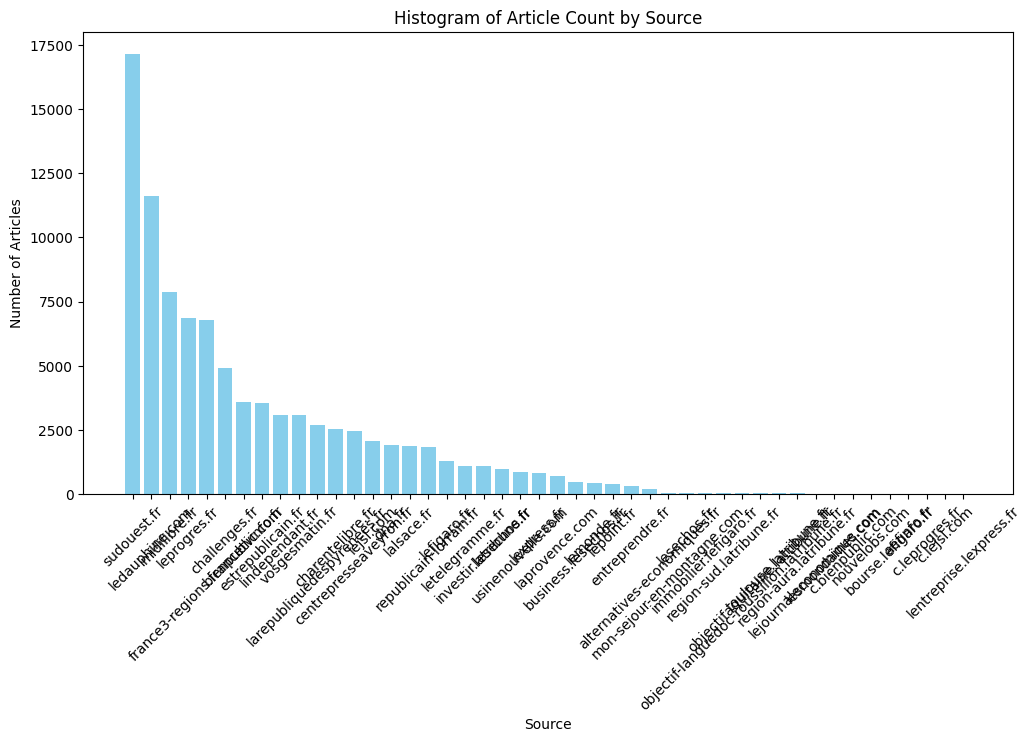

In [72]:
source_counts = df['source'].value_counts()

# Plot histogram with increased x-axis size
plt.figure(figsize=(12, 6))  # Increase x-axis size
plt.bar(source_counts.index, source_counts.values, color='skyblue')
plt.xlabel('Source')
plt.ylabel('Number of Articles')
plt.title('Histogram of Article Count by Source')
plt.xticks(rotation=45)
plt.show()

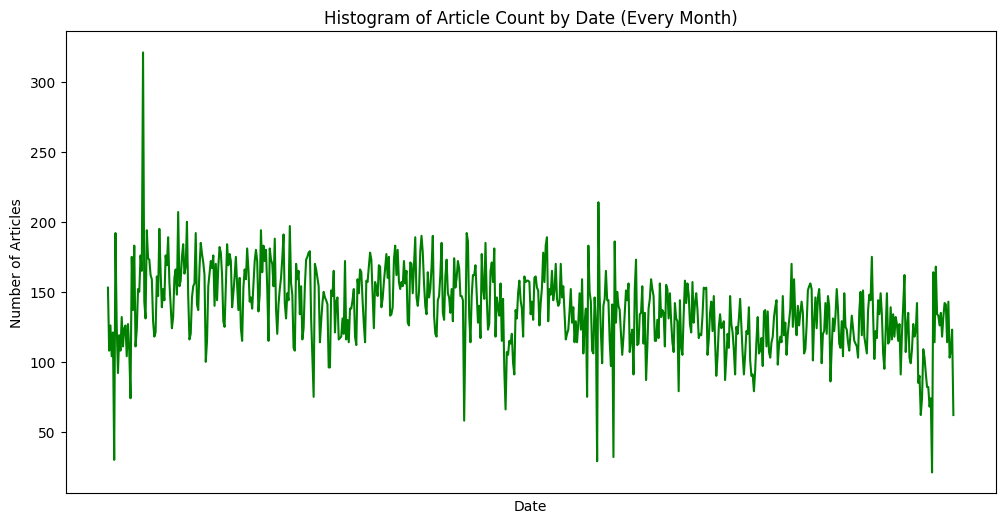

In [73]:
date_counts = df['date'].value_counts().sort_index()

# Convert date indices to DatetimeIndex
date_indices = pd.to_datetime(date_counts.index)

# Select every month
date_indices = date_indices[date_indices.to_series().dt.is_month_end]

plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values, color='green')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Histogram of Article Count by Date (Every Month)')
plt.xticks(rotation=45)
plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis labels
plt.show()

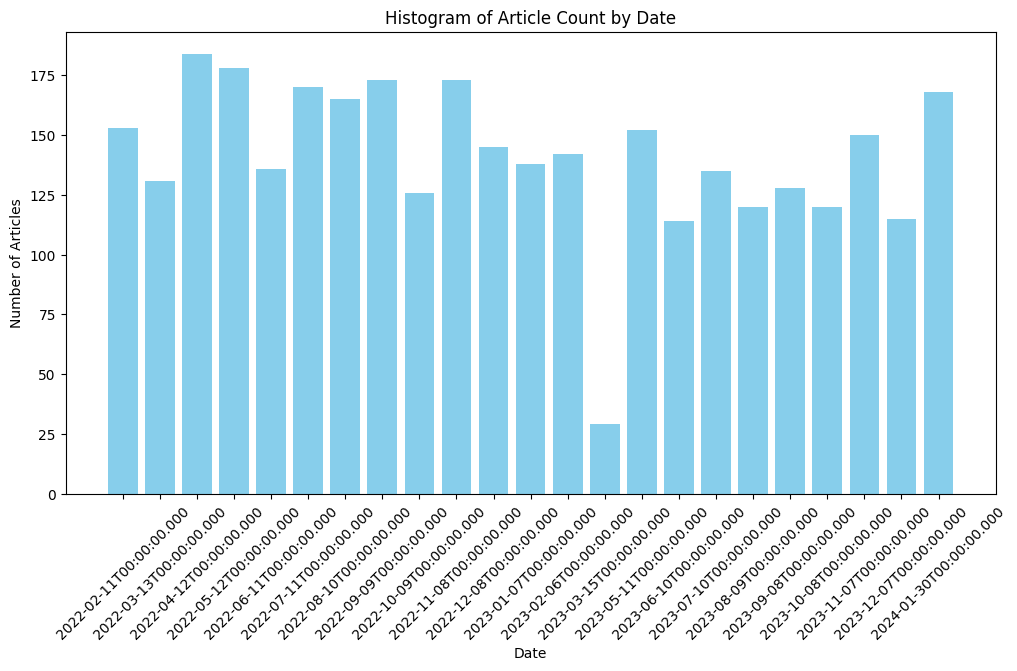

In [74]:
date_counts = df['date'].value_counts().sort_index()

date_indices = date_counts.index[::30]
date_values = date_counts.loc[date_indices]

plt.figure(figsize=(12, 6))
plt.bar(date_indices, date_values, color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.title('Histogram of Article Count by Date')
plt.xticks(rotation=45)
plt.show()

In [ ]:
sources = df['source'].unique()
sources.shape

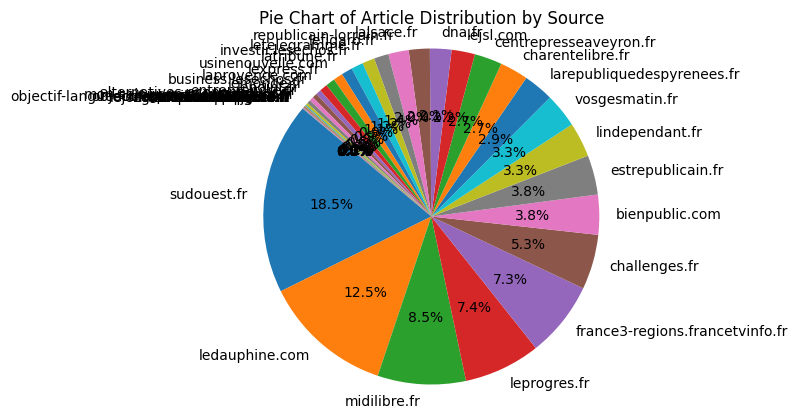

In [75]:
source_counts = df['source'].value_counts()
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Pie Chart of Article Distribution by Source')
plt.show()

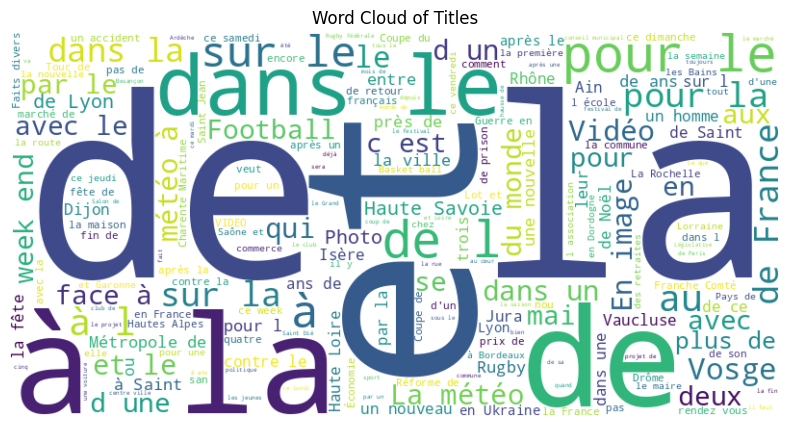

In [76]:
title_text = ' '.join(df['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Titles')
plt.show()

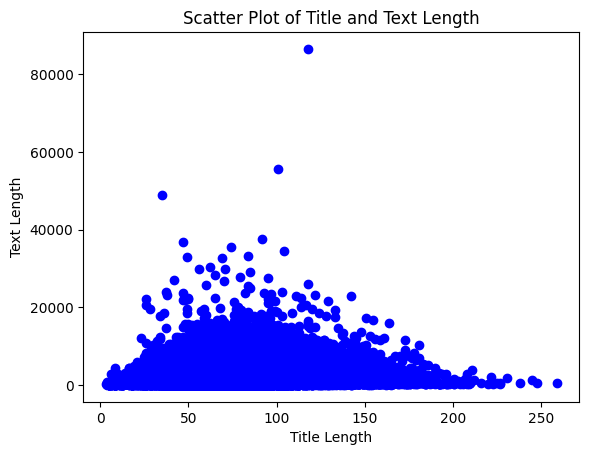

In [77]:
title_lengths = df['title'].str.len()
text_lengths = df['text'].str.len()
plt.scatter(title_lengths, text_lengths, color='blue')
plt.xlabel('Title Length')
plt.ylabel('Text Length')
plt.title('Scatter Plot of Title and Text Length')
plt.show()

## Data preprocessing

In [78]:
nlp = spacy.load("fr_core_news_sm", disable=['parser', 'ner'])

/home/gasp/.local/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/gasp/.local/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [79]:
def preprocess(text):
    doc = nlp(text)
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(preprocessed_tokens)

In [81]:
# df['text'] = df['text'].apply(preprocess)

In [82]:
from tqdm.notebook import tqdm

In [83]:
tqdm.pandas()

In [84]:
df['preprocessed_text'] = df['text'].progress_apply(preprocess)

  0%|          | 0/93095 [00:00<?, ?it/s]

In [ ]:
from joblib import Parallel, delayed

In [ ]:
num_jobs = -1  # Use all available CPU cores

# Apply the function to the 'text' column using parallel processing
df['text'] = Parallel(n_jobs=num_jobs)(delayed(remove_stopwords)(text) for text in df['text'])

## Model training

In [ ]:
# nettoyage : nb titre/description correct
# période couverte/histogramme selon le nettoyage
# lsa/plsa
# objectif : détection d'évènements = topic dans une fenêtre de temps
# comparer temps et qualité des résultats
# afficher nuage de mots
# compter le nb journaux (domaine/feed) faire histogramme par source
# demain 16h15
# comment découvrir un jeu de données textuelle

## Testing